<h1>Лабораторная работа 3</h1>
<h2>Классификация в sklearn. Метрики классификации</h2>

Выполнил: 6131 Чаплыгин Алексей Олегович

<h2>0. Набор данных</h2>
Выберите наборы данных, подходящие для многоклассовой и бинарной классификации. Опишите данные, что обозначает каждый столбец, какого типа (категориальный, вещественный, целочисленный, бинарный) данный столбец, при необходимости для категориальных в том числе бинарных признаков привести расшифровку их значений. В общем, проведите "визуальный" анализ ваших данных.</br>
Используемый в работе набор данных доступен по следующей ссылке: https://www.kaggle.com/rankirsh/evolution-of-top-games-on-twitch и описывает рейтинг популярных 200 игр, транслируемых на платформе Twitch с 2016 по 2021 года.
В наборе данных содержится таблица с 12 столбцами.</br>
<table border="1">
   <caption>Top games on Twitch 2016 - 2021</caption>
   <tr>
    <th>Номер столбца</th>
    <th>Название столбца</th>
    <th>Описание столбца</th>
   </tr>
   <tr><td>1</td><td>Rank</td><td>Значение рейтинга</td></tr>
   <tr><td>2</td><td>Game</td><td>Наименование игры</td></tr>
   <tr><td>3</td><td>Month</td><td>Месяц</td></tr>
   <tr><td>4</td><td>Year</td><td>Год</td></tr>
   <tr><td>5</td><td>Hours_watched</td><td>Колчествао часов, которое зрители смотрели</td></tr>
   <tr><td>6</td><td>Hours_Streamed</td><td>Количество часов, которое стримеры стримили</td></tr>
   <tr><td>7</td><td>Peak_viewers</td><td>Максимальное количество зрителей</td></tr>
   <tr><td>8</td><td>Peak_channels</td><td>Максимальное количество каналов на которых происходила трансляция одновременно</td></tr>
   <tr><td>9</td><td>Streamers</td><td>Всего стримеров, которые стримили эту игру</td></tr>
   <tr><td>10</td><td>Avg_viewers</td><td>Среднее количество просмотров</td></tr>
   <tr><td>11</td><td>Avg_channels</td><td>Среднее количество каналов</td></tr>
   <tr><td>12</td><td>Avg_viewer_ratio</td><td>Средний коэффициент просмотров</td></tr>
  </table>

<h2>Дополнительная информация</h2>
<ul>
  <li><a href="https://habr.com/ru/company/piter/blog/488362/">[HABR] Классификация с многими метками</a></li>
  <li><a href="https://docs.microsoft.com/ru-ru/azure/machine-learning/component-reference/one-vs-all-multiclass">[Microsoft - Azure] Многоклассовая классификация "один-все"</a></li>
</ul>

In [1]:
# PRE INIT ROW
# for new libraries if need
# !pip install 

In [2]:
# INIT IMPORT
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from scipy.stats import probplot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_recall_curve, classification_report, confusion_matrix, accuracy_score, roc_curve

import warnings
warnings.filterwarnings("ignore")

In [3]:
# MAIN FUNCS

# Функция условной градации классов на основании рейтига
def class_ratio(r):
    if r > (max(data_exp['Avg_viewer_ratio']) / 3) :
        c = 1
    elif r < (max(data_exp['Avg_viewer_ratio']) / 3) and r > (max(data_exp['Avg_viewer_ratio']) / 4):
        c = 2
    elif r < (max(data_exp['Avg_viewer_ratio']) / 5):
        c = 3
    else:
        c = 0
    return c

# Функция условной бинарной градации записей на основании рейтига
def binary_ratio(r):
    if r > 10000 :
        c = 'High'
    else:
        c = 'Low'
    return c

# Функция определениея точности в %
def evaluate(P, T):
    # P - Предсказанные значение
    # T - Истинные значения
    # accuracy = correct predictions / all predictions
    accuracy = np.mean(P == T)
    return accuracy*100

In [4]:
data = pd.read_csv('data/Twitch_game_data.csv', sep=',', encoding='windows-1251')

In [5]:
data.head()

,Rank,Game,Month,Year,Hours_watched,Hours_Streamed,Peak_viewers,Peak_channels,Streamers,Avg_viewers,Avg_channels,Avg_viewer_ratio
0,1,League of Legends,1,2016,94377226,1362044 hours,530270,2903,129172,127021,1833,69.29
1,2,Counter-Strike: Global Offensive,1,2016,47832863,830105 hours,372654,2197,120849,64378,1117,57.62
2,3,Dota 2,1,2016,45185893,433397 hours,315083,1100,44074,60815,583,104.26
3,4,Hearthstone,1,2016,39936159,235903 hours,131357,517,36170,53749,317,169.29
4,5,Call of Duty: Black Ops III,1,2016,16153057,1151578 hours,71639,3620,214054,21740,1549,14.03


<h2> 1. Многоклассовая классификация:</h2> 
<ol>
    <li>На любом датасете продемонстрировать многоклассовую классификацию с помощью ЛЮБОГО алгоритма. Оценить accuracy.</li>
    <li>То же самое с использованием кросс-валидации</li>
    <li>Поиграться с гиперпараметром, связанным со сложностью модели (в случае kNN — k_neighbours) и построить график accuracy для train set и test_set для разных значений гиперпараметра (в лекции есть пример построения подобного графика для kNN и датасета cancer, но можно строить как угодно такой график)</li>
    <li>Построить confusion matrix (это вроде матрицы TN / TP/ FN/ FP, только расширенной для многоклассовой классификации, чтобы понять в какие стороны чаще ошибается классификатор)</li>
</ol> 

In [6]:
# Преобразуем данные и добавляем условыне классы на основании рейтинга Avg_viewer_ratio
data_exp = data.copy()

max(data_exp['Avg_viewer_ratio'])

13601.87

In [40]:
data_exp['Hours_Streamed'] = data_exp.apply(lambda x: x['Hours_Streamed'].replace(' hours', '') , axis=1)
data_exp['Class_Ratio'] = data_exp.apply(lambda row: class_ratio(row['Avg_viewer_ratio']), axis = 1)
data_exp = data_exp.drop(columns = ['Game', 'Rank'], axis = 1)
data_exp.head()

KeyError: "['Game' 'Rank'] not found in axis"

In [11]:
max(data_exp['Class_Ratio'])

3

In [12]:
data_exp['Class_Ratio'].value_counts()

3    14353
1       22
2       18
0        7
Name: Class_Ratio, dtype: int64

In [13]:
data_exp.shape

(14400, 11)

In [14]:
# Делим набор данных
X = data_exp.iloc[:, 0:9].values
Y = data_exp.iloc[:, 10].values

# Формируем обучающую и тестовую выборки
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25, random_state = 25)

In [15]:
X_train.shape, X_test.shape

((10800, 9), (3600, 9))

In [16]:
len(Y_train), len(Y_test)

(10800, 3600)

<h3>sklearn.ensemble.RandomForestClassifier</h3>
Параметры:</br>
<ul>
    <li>n_estimators - число деревьев в классификации случайных лесов</li>
    <li>критерий - функция потерь (джини или энтропия)</li>
    <li>random_state - начальное значение, используемое генератором случайных состояний для рандомизации набора данныхв</li>
</ul> 

In [17]:
# обучение
model_Tree = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
model_Tree.fit(X_train, Y_train)

RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=42)

In [18]:
Y_Tree = model_Tree.predict(X_test)

In [19]:
compare = np.vstack([Y_Tree, Y_test]).T
compare

array([[3, 3],
       [3, 3],
       [3, 3],
       ...,
       [3, 3],
       [3, 3],
       [3, 3]], dtype=int64)

In [20]:
# Вычисление матрицы ошибок
# (i, j) элементы матрицы показывают число элементов класса `i` отнесённых классификатором к классу `j`
# i - строки
# j - столбцы
conf_mat_Tree = confusion_matrix(Y_test, Y_Tree)
conf_mat_Tree

array([[   0,    1,    0,    0],
       [   0,    5,    1,    0],
       [   0,    1,    3,    1],
       [   0,    0,    0, 3588]], dtype=int64)

<AxesSubplot:>

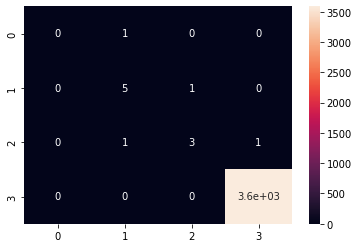

In [21]:
# Визуализация матрицы ошибок
sns.heatmap(conf_mat_Tree, annot=True)

In [22]:
# точность
print (f'Evaluate = {evaluate(Y_Tree, Y_test)}%')
# accuracy
print (f'Accuracy = {accuracy_score(Y_test, Y_Tree) * 100}%')

Evaluate = 99.8888888888889%
Accuracy = 99.8888888888889%


In [23]:
report_Tree = classification_report(Y_test, Y_Tree)
print(report_Tree)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.71      0.83      0.77         6
           2       0.75      0.60      0.67         5
           3       1.00      1.00      1.00      3588

    accuracy                           1.00      3600
   macro avg       0.62      0.61      0.61      3600
weighted avg       1.00      1.00      1.00      3600



<h3>sklearn.naive_bayes.GaussianNB</h3>

In [24]:
# Инициализиуем классификатор
model_Gauss = GaussianNB()
# Обучаем
model_Gauss.fit(X_train, Y_train)
# Предсказываем
Y_Gauss = model_Gauss.predict(X_test)
         
# Вычисление матрицы ошибок
conf_mat_Gauss = confusion_matrix(Y_test, Y_Gauss)
conf_mat_Gauss         

array([[   0,    1,    0,    0],
       [   0,    5,    1,    0],
       [   0,    2,    2,    1],
       [  89,   82,   96, 3321]], dtype=int64)

<AxesSubplot:>

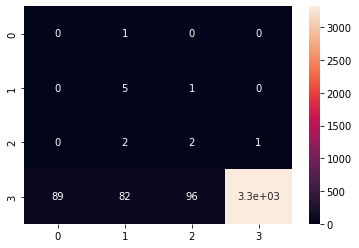

In [25]:
# Визуализация матрицы ошибок
sns.heatmap(conf_mat_Gauss, annot=True)

In [26]:
# точность
print (f'Evaluate = {evaluate(Y_Tree, Y_test)}%')
# accuracy
print (f'Accuracy = {accuracy_score(Y_test, Y_Tree) * 100}%')

Evaluate = 99.8888888888889%
Accuracy = 99.8888888888889%


In [27]:
report_Gauss = classification_report(Y_test, Y_Gauss)
print(report_Gauss)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.06      0.83      0.10         6
           2       0.02      0.40      0.04         5
           3       1.00      0.93      0.96      3588

    accuracy                           0.92      3600
   macro avg       0.27      0.54      0.28      3600
weighted avg       1.00      0.92      0.96      3600



<h3>sklearn.neighbors.KNeighborsClassifier</h3>
Параметры:</br>
<ul>
    <li>n_neighbors - Количество соседей, используемых по умолчанию для запросов соседей.</li>
</ul> 

In [28]:
# Проверим на 5 соседях
model_KNBC = KNeighborsClassifier(n_neighbors = 5)
model_KNBC.fit(X_train, Y_train)
Y_KNBC = model_KNBC.predict(X_test)
  
accuracy_score(Y_test, Y_KNBC) 

0.9963888888888889

In [29]:
# Выполним автоматический подбор оптимального количества соседей
best_n_count = 0
max_accuracy = 0

for i in range(1, 128):
    tmp_model_KNBC = KNeighborsClassifier(n_neighbors = i)
    tmp_model_KNBC.fit(X_train, Y_train)
    predict_i = tmp_model_KNBC.predict(X_test)
    ac = accuracy_score(Y_test, predict_i)
    if ac > max_accuracy:
        max_accuracy = ac
        best_n_count = i
        
# Выполним оценку для оптимального количества соседей
optimal_model_KNBC = KNeighborsClassifier(n_neighbors = best_n_count)
optimal_model_KNBC.fit(X_train, Y_train)
Y_KNBCO = optimal_model_KNBC.predict(X_test)

# Оптимальное количество соседей
print (f'Оптимальное количество соседей = {best_n_count}')
# accuracy
print (f'Accuracy = {accuracy_score(Y_test, Y_KNBCO) * 100}%')

Оптимальное количество соседей = 4
Accuracy = 99.66666666666667%


In [30]:
# Визуализация матрицы ошибок
conf_mat_KNBCO = confusion_matrix(Y_test, Y_KNBCO)
conf_mat_KNBCO

array([[   0,    0,    0,    1],
       [   0,    0,    0,    6],
       [   0,    0,    0,    5],
       [   0,    0,    0, 3588]], dtype=int64)

<AxesSubplot:>

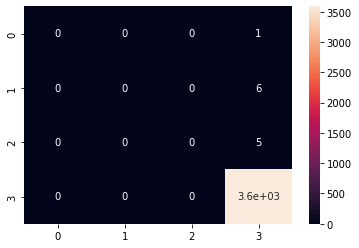

In [31]:
sns.heatmap(conf_mat_KNBCO, annot=True)

In [32]:
# Нормализованные данные
scaler = StandardScaler()
X_train_M = scaler.fit_transform(X_train)
X_test_M = scaler.transform(X_test)

model_KNBCM = KNeighborsClassifier(n_neighbors = best_n_count)
model_KNBCM.fit(X_train_M, Y_train)

Y_KNBCM = model_KNBCM.predict(X_test_M)

# accuracy
print (f'Accuracy = {accuracy_score(Y_test, Y_KNBCM) * 100}%')

Accuracy = 99.66666666666667%


<h2>2. Бинарная классификация.</h2>
На любом (но уже другом, бинарном) датасете продемонстрировать бинарную классификацию (можно использовать любой алгоритм), посчитать метрики: accuracy, precision, recall, f-measure, а также составить classification_report.

In [33]:
# Преобразуем данные и добавляем условыне классы на основании рейтинга Avg_viewer_ratio
data_binary = data.copy()
data_binary['Hours_Streamed'] = data_binary.apply(lambda x: x['Hours_Streamed'].replace(' hours', '') , axis=1)
data_binary['Binary_Ratio'] = data_binary.apply(lambda row: binary_ratio(row['Avg_viewer_ratio']), axis = 1)
data_binary = data_binary.drop(columns = ['Game', 'Rank'], axis = 1)

data_binary.head()

,Month,Year,Hours_watched,Hours_Streamed,Peak_viewers,Peak_channels,Streamers,Avg_viewers,Avg_channels,Avg_viewer_ratio,Binary_Ratio
0,1,2016,94377226,1362044,530270,2903,129172,127021,1833,69.29,Low
1,1,2016,47832863,830105,372654,2197,120849,64378,1117,57.62,Low
2,1,2016,45185893,433397,315083,1100,44074,60815,583,104.26,Low
3,1,2016,39936159,235903,131357,517,36170,53749,317,169.29,Low
4,1,2016,16153057,1151578,71639,3620,214054,21740,1549,14.03,Low


In [34]:
# Делим набор данных
XB = data_binary.iloc[:, 0:9].values
YB = data_binary.iloc[:, 10].values

# Формируем обучающую и тестовую выборки
XB_train, XB_test, YB_train, YB_test = train_test_split(XB, YB, test_size = 0.25, random_state = 25)

In [35]:
model_LR = LogisticRegression()
    
model_LR.fit(XB_train, YB_train)
Y_Log = model_LR.predict(XB_test)

# accuracy
print (f'Accuracy = {accuracy_score(YB_test, Y_Log) * 100}%')

Accuracy = 99.97222222222221%


In [36]:
# Визуализация матрицы ошибок
cf_Log = confusion_matrix(YB_test, Y_Log)
cf_Log

array([[   1,    0],
       [   1, 3598]], dtype=int64)

<AxesSubplot:>

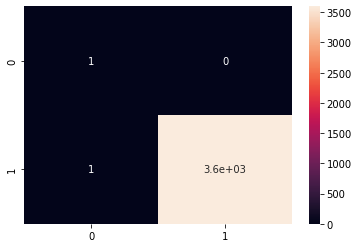

In [37]:
sns.heatmap(cf_Log, annot=True)

In [38]:
# Нормализованные данные
scaler = StandardScaler()
XB_train_M = scaler.fit_transform(XB_train)
XB_test_M = scaler.transform(XB_test)

model_LogM = LogisticRegression()
    
model_LogM.fit(XB_train_M, YB_train)
Y_LogM = model_LogM.predict(XB_test_M)
        
accuracy_score(YB_test, Y_LogM)

# accuracy
print (f'Accuracy = {accuracy_score(YB_test, Y_LogM) * 100}%')

Accuracy = 99.97222222222221%


<h2>3. Использование нормализации признаков</h2>
В обоих задачах (бинарной и многоклассовой классификации) попробовать также вариант с предварительной нормализацией признаков (StandardScalerили MinMaxScaler). Оценить метрики качества в случае с нормализованными признаками и ненормализованными.</br>

In [39]:
# accuracy
print (f'Accuracy = {accuracy_score(Y_test, Y_KNBC) * 100}%')
print (f'Accuracy StandardScaler = {accuracy_score(Y_test, Y_KNBCM) * 100}%')

print (f'Binary Accuracy = {accuracy_score(YB_test, Y_Log) * 100}%')
print (f'Binary Accuracy StandardScaler = {accuracy_score(YB_test, Y_LogM) * 100}%')

Accuracy = 99.63888888888889%
Accuracy StandardScaler = 99.66666666666667%
Binary Accuracy = 99.97222222222221%
Binary Accuracy StandardScaler = 99.97222222222221%


<h2>Вывод</h2>
Либо разница не большая, либо я неверно выполнил задание, либо такой неудачный набор данных, скорее всего полседний вариант.